## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.7]
redice_lr_patient = [3, 5, 7]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 11/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.5135 - acc: 0.4694 - val_loss: 1.6280 - val_acc: 0.4310
Epoch 12/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.4920 - acc: 0.4797 - val_loss: 1.6204 - val_acc: 0.4316
Epoch 13/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4737 - acc: 0.4838 - val_loss: 1.6081 - val_acc: 0.4395
Epoch 14/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4553 - acc: 0.4920 - val_loss: 1.5957 - val_acc: 0.4410
Epoch 15/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4386 - acc: 0.4986 - val_loss: 1.5900 - val_acc: 0.4431
Epoch 16/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.4226 - acc: 0.5024 - val_loss: 1.5775 - val_acc: 0.4459
Epoch 17/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.4075 - acc: 0.5073 - val_loss: 1.5717 - val_acc: 0.4478
Epoch 18/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 170us/step - loss: 2.5000 - acc: 0.1997 - val_loss: 2.3114 - val_acc: 0.2599
Epoch 2/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.9902 - acc: 0.3233 - val_loss: 1.9885 - val_acc: 0.3329
Epoch 3/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.8382 - acc: 0.3668 - val_loss: 1.8879 - val_acc: 0.3579
Epoch 4/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.7529 - acc: 0.3924 - val_loss: 1.8168 - val_acc: 0.3795
Epoch 5/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6939 - acc: 0.4116 - val_loss: 1.7678 - val_acc: 0.3903
Epoch 6/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.6474 - acc: 0.4253 - val_loss: 1.7355 - val_acc: 0.4002
Epoch 7/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6093 - acc: 0.4381 - val_loss: 1.6993 - 

Epoch 24/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.2970 - acc: 0.5472 - val_loss: 1.5360 - val_acc: 0.4562
Epoch 25/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.2862 - acc: 0.5530 - val_loss: 1.5353 - val_acc: 0.4594
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batc

50000/50000 [==============================] - 6s 125us/step - loss: 1.5060 - acc: 0.4781 - val_loss: 1.6336 - val_acc: 0.4317
Epoch 12/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.4853 - acc: 0.4832 - val_loss: 1.6155 - val_acc: 0.4392
Epoch 13/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4673 - acc: 0.4915 - val_loss: 1.6074 - val_acc: 0.4408
Epoch 14/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4488 - acc: 0.4974 - val_loss: 1.5978 - val_acc: 0.4434
Epoch 15/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4325 - acc: 0.5032 - val_loss: 1.5893 - val_acc: 0.4471
Epoch 16/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4160 - acc: 0.5092 - val_loss: 1.5767 - val_acc: 0.4528
Epoch 17/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4007 - acc: 0.5141 - val_loss: 1.5744 - val_acc: 0.4510
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 187us/step - loss: 2.5148 - acc: 0.2038 - val_loss: 2.2958 - val_acc: 0.2696
Epoch 2/25
50000/50000 [==============================] - 6s 123us/step - loss: 2.0022 - acc: 0.3231 - val_loss: 2.0006 - val_acc: 0.3229
Epoch 3/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.8422 - acc: 0.3637 - val_loss: 1.8792 - val_acc: 0.3631
Epoch 4/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.7536 - acc: 0.3922 - val_loss: 1.8152 - val_acc: 0.3794
Epoch 5/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.6948 - acc: 0.4100 - val_loss: 1.7607 - val_acc: 0.3933
Epoch 6/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.6493 - acc: 0.4268 - val_loss: 1.7245 - val_acc: 0.4005
Epoch 7/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.6124 - acc: 0.4387 - val_loss: 1.7015 - 


Epoch 00022: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 23/25
50000/50000 [==============================] - 7s 137us/step - loss: 0.4828 - acc: 0.8597 - val_loss: 1.4156 - val_acc: 0.5400
Epoch 24/25
50000/50000 [==============================] - 7s 137us/step - loss: 0.4776 - acc: 0.8619 - val_loss: 1.4197 - val_acc: 0.5410
Epoch 25/25
50000/50000 [==============================] - 7s 142us/step - loss: 0.4734 - acc: 0.8653 - val_loss: 1.4249 - val_acc: 0.5398
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)       

50000/50000 [==============================] - 7s 137us/step - loss: 1.5058 - acc: 0.4758 - val_loss: 1.6353 - val_acc: 0.4282
Epoch 10/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.4865 - acc: 0.4827 - val_loss: 1.6296 - val_acc: 0.4269
Epoch 11/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4695 - acc: 0.4881 - val_loss: 1.6153 - val_acc: 0.4330
Epoch 12/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.4536 - acc: 0.4931 - val_loss: 1.6067 - val_acc: 0.4369
Epoch 13/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.4401 - acc: 0.4999 - val_loss: 1.6002 - val_acc: 0.4353
Epoch 14/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.4260 - acc: 0.5050 - val_loss: 1.5957 - val_acc: 0.4384
Epoch 15/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.4125 - acc: 0.5104 - val_loss: 1.5898 - val_acc: 0.4416
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 229us/step - loss: 2.1869 - acc: 0.2795 - val_loss: 2.0175 - val_acc: 0.3310
Epoch 2/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.8033 - acc: 0.3770 - val_loss: 1.8689 - val_acc: 0.3754
Epoch 3/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.7016 - acc: 0.4099 - val_loss: 1.7942 - val_acc: 0.3918
Epoch 4/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6424 - acc: 0.4267 - val_loss: 1.7266 - val_acc: 0.4105
Epoch 5/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.5990 - acc: 0.4422 - val_loss: 1.7030 - val_acc: 0.4162
Epoch 6/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.5662 - acc: 0.4544 - val_loss: 1.6834 - val_acc: 0.4247
Epoch 7/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.5382 - acc: 0.4647 - val_loss: 1.6641 -

Epoch 24/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.3092 - acc: 0.5464 - val_loss: 1.5413 - val_acc: 0.4610
Epoch 25/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2997 - acc: 0.5518 - val_loss: 1.5364 - val_acc: 0.4646
Numbers of exp: 15, reduce_factor: 0.70, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 7s 139us/step - loss: 1.4664 - acc: 0.4900 - val_loss: 1.6079 - val_acc: 0.4392
Epoch 12/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.4501 - acc: 0.4972 - val_loss: 1.5970 - val_acc: 0.4421
Epoch 13/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.4358 - acc: 0.5029 - val_loss: 1.5951 - val_acc: 0.4456
Epoch 14/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4213 - acc: 0.5061 - val_loss: 1.5903 - val_acc: 0.4478
Epoch 15/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4081 - acc: 0.5121 - val_loss: 1.5837 - val_acc: 0.4477
Epoch 16/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.3965 - acc: 0.5153 - val_loss: 1.5797 - val_acc: 0.4516
Epoch 17/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.3836 - acc: 0.5208 - val_loss: 1.5706 - val_acc: 0.4543
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 251us/step - loss: 1.8012 - acc: 0.3741 - val_loss: 2.2124 - val_acc: 0.2902
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.5369 - acc: 0.4569 - val_loss: 2.6025 - val_acc: 0.2655
Epoch 3/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.4308 - acc: 0.4934 - val_loss: 2.5517 - val_acc: 0.2171
Epoch 4/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3519 - acc: 0.5239 - val_loss: 2.5652 - val_acc: 0.2848

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.2113 - acc: 0.5777 - val_loss: 1.7370 - val_acc: 0.3844
Epoch 6/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.1581 - acc: 0.5960 - val_loss: 1.7202 - val_acc: 0.3945
Epoch 7/25
50000/50000 [================

50000/50000 [==============================] - 7s 135us/step - loss: 1.1520 - acc: 0.6087 - val_loss: 1.5017 - val_acc: 0.4742
Epoch 23/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.1376 - acc: 0.6140 - val_loss: 1.5094 - val_acc: 0.4794
Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.1202 - acc: 0.6222 - val_loss: 1.5110 - val_acc: 0.4783
Epoch 25/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.1052 - acc: 0.6274 - val_loss: 1.5032 - val_acc: 0.4748
Numbers of exp: 20, reduce_factor: 0.30, reduce_patient: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
b

50000/50000 [==============================] - 7s 135us/step - loss: 1.4495 - acc: 0.4993 - val_loss: 1.6256 - val_acc: 0.4366
Epoch 10/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.4206 - acc: 0.5102 - val_loss: 1.6044 - val_acc: 0.4445
Epoch 11/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3931 - acc: 0.5207 - val_loss: 1.5866 - val_acc: 0.4544
Epoch 12/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3672 - acc: 0.5284 - val_loss: 1.5821 - val_acc: 0.4557
Epoch 13/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.3428 - acc: 0.5382 - val_loss: 1.5716 - val_acc: 0.4576
Epoch 14/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3195 - acc: 0.5459 - val_loss: 1.5708 - val_acc: 0.4596
Epoch 15/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.2990 - acc: 0.5549 - val_loss: 1.5507 - val_acc: 0.4646
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 266us/step - loss: 2.2464 - acc: 0.2556 - val_loss: 2.0526 - val_acc: 0.3072
Epoch 2/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.8822 - acc: 0.3521 - val_loss: 1.9216 - val_acc: 0.3484
Epoch 3/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.7500 - acc: 0.3929 - val_loss: 1.8083 - val_acc: 0.3822
Epoch 4/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6635 - acc: 0.4222 - val_loss: 1.7584 - val_acc: 0.3915
Epoch 5/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6022 - acc: 0.4410 - val_loss: 1.7142 - val_acc: 0.4029
Epoch 6/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.5523 - acc: 0.4592 - val_loss: 1.6753 - val_acc: 0.4208
Epoch 7/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.5097 - acc: 0.4737 - val_loss: 1.6616 -

Epoch 24/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.1274 - acc: 0.6206 - val_loss: 1.4857 - val_acc: 0.4826
Epoch 25/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1131 - acc: 0.6253 - val_loss: 1.4947 - val_acc: 0.4818
Numbers of exp: 25, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 7s 139us/step - loss: 1.3849 - acc: 0.5203 - val_loss: 1.5903 - val_acc: 0.4429
Epoch 12/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.3581 - acc: 0.5322 - val_loss: 1.5699 - val_acc: 0.4496
Epoch 13/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.3343 - acc: 0.5412 - val_loss: 1.5568 - val_acc: 0.4515
Epoch 14/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.3120 - acc: 0.5500 - val_loss: 1.5597 - val_acc: 0.4588
Epoch 15/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2895 - acc: 0.5565 - val_loss: 1.5492 - val_acc: 0.4602
Epoch 16/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.2698 - acc: 0.5662 - val_loss: 1.5532 - val_acc: 0.4628
Epoch 17/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.2495 - acc: 0.5730 - val_loss: 1.5382 - val_acc: 0.4690
Epoch 18/25
50000/50000 [==============

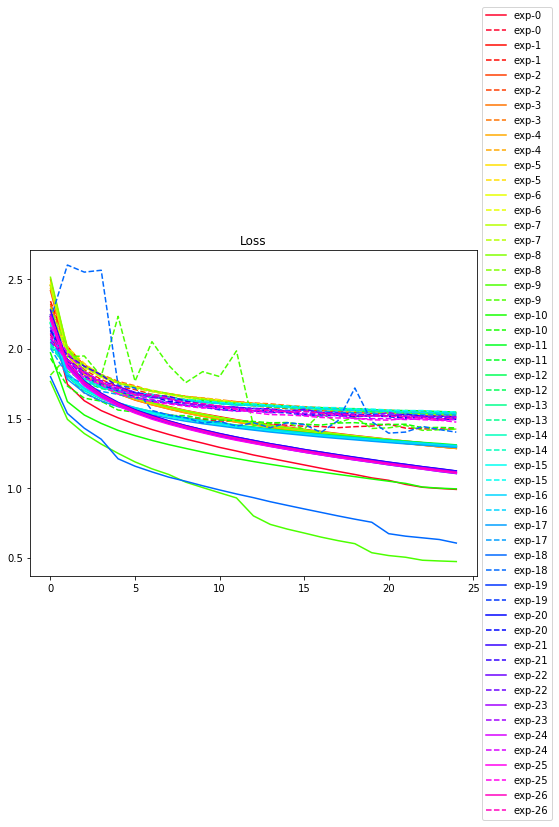

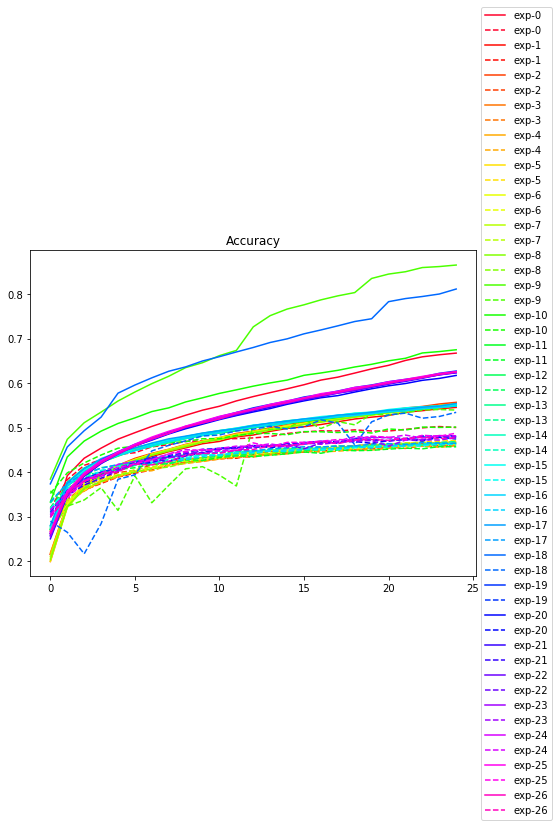

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()